<a href="https://colab.research.google.com/github/adriendod/behavioral-cloning/blob/master/Udacity_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Data Science/Dataset udacity/datazip/Archive.zip" -d "/content/data/"

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from PIL import Image
from google.colab import files
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
imagedir = "/content/data/IMG"
df = pd.read_csv("/content/data/driving_log.csv",header=None, names=["center", "left", "right", "steering", "acceleration", "breaking", "speed" ])
df.replace("/Users/adriendodinet/Downloads/beta_simulator_mac", "/content/data", regex=True, inplace=True)

In [0]:
df.iloc[100:110]

,center,left,right,steering,acceleration,breaking,speed
100,/content/data/IMG/center_2019_09_09_21_56_39_9...,/content/data/IMG/left_2019_09_09_21_56_39_958...,/content/data/IMG/right_2019_09_09_21_56_39_95...,-0.016212,1.0,0,30.19031
101,/content/data/IMG/center_2019_09_09_21_56_40_0...,/content/data/IMG/left_2019_09_09_21_56_40_050...,/content/data/IMG/right_2019_09_09_21_56_40_05...,-0.019149,1.0,0,30.19029
102,/content/data/IMG/center_2019_09_09_21_56_40_1...,/content/data/IMG/left_2019_09_09_21_56_40_128...,/content/data/IMG/right_2019_09_09_21_56_40_12...,-0.019149,1.0,0,30.19027
103,/content/data/IMG/center_2019_09_09_21_56_40_2...,/content/data/IMG/left_2019_09_09_21_56_40_201...,/content/data/IMG/right_2019_09_09_21_56_40_20...,-0.019149,1.0,0,30.19027
104,/content/data/IMG/center_2019_09_09_21_56_40_2...,/content/data/IMG/left_2019_09_09_21_56_40_297...,/content/data/IMG/right_2019_09_09_21_56_40_29...,-0.019149,1.0,0,30.19031
105,/content/data/IMG/center_2019_09_09_21_56_40_4...,/content/data/IMG/left_2019_09_09_21_56_40_405...,/content/data/IMG/right_2019_09_09_21_56_40_40...,-0.019149,1.0,0,30.19028
106,/content/data/IMG/center_2019_09_09_21_56_40_5...,/content/data/IMG/left_2019_09_09_21_56_40_512...,/content/data/IMG/right_2019_09_09_21_56_40_51...,-0.019149,1.0,0,30.19027
107,/content/data/IMG/center_2019_09_09_21_56_40_5...,/content/data/IMG/left_2019_09_09_21_56_40_594...,/content/data/IMG/right_2019_09_09_21_56_40_59...,-0.019149,1.0,0,30.19028
108,/content/data/IMG/center_2019_09_09_21_56_40_6...,/content/data/IMG/left_2019_09_09_21_56_40_671...,/content/data/IMG/right_2019_09_09_21_56_40_67...,-0.019149,1.0,0,30.19027
109,/content/data/IMG/center_2019_09_09_21_56_40_7...,/content/data/IMG/left_2019_09_09_21_56_40_759...,/content/data/IMG/right_2019_09_09_21_56_40_75...,-0.016242,1.0,0,30.19030


Text(0.5, 1.0, 'Right image')

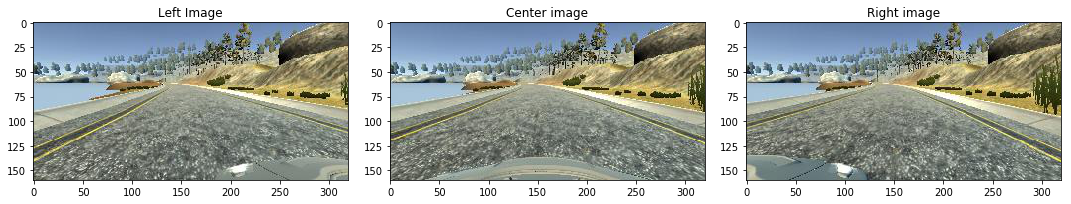

In [0]:
center_img = mpimg.imread(df["center"][0])

left_img = mpimg.imread(df["left"][0])

right_img = mpimg.imread(df["right"][0])


fig, ax = plt.subplots(1, 3, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(left_img)
ax[0].set_title("Left Image")
ax[1].imshow(center_img)
ax[1].set_title("Center image")
ax[2].imshow(right_img)
ax[2].set_title("Right image")

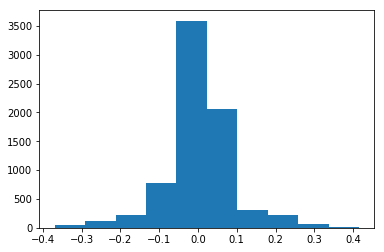

In [0]:
plt.hist(df['steering'])
plt.show()

In [0]:
def load_img(imagedir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    for col in range(0,3):
      image = indexed_data[col]
      image_path.append(os.path.join(imagedir, image.strip()))
      if col == 1:
        adjusted_steering = indexed_data[3] + 0.1
        if adjusted_steering > 0.5:
          adjusted_steering = 0.5
      elif col == 2:
        adjusted_steering = indexed_data[3] - 0.1
        if adjusted_steering < -0.5:
          adjusted_steering = -0.5
      else:
        adjusted_steering = indexed_data[3]       
      steering.append(adjusted_steering)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
  
image_paths, steerings = load_img(imagedir, df)
    

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
original_image.shape

(160, 320, 3)

In [0]:
steerings

array([ 0. ,  0.1, -0.1, ...,  0. ,  0.1, -0.1])

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:140, :,: ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = img/255
  return img

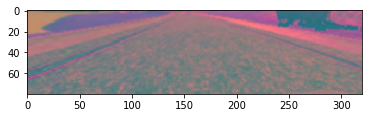

In [0]:
img = img_preprocess(image_paths[100])
plt.imshow(img)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings,test_size = 0.2, random_state = 42)
print('Training Samples: {}\nTest Samples: {}'.format(len(X_train), len(X_test)))

Training Samples: 17748
Test Samples: 4437


Text(0.5, 1.0, 'Preprocessed image')

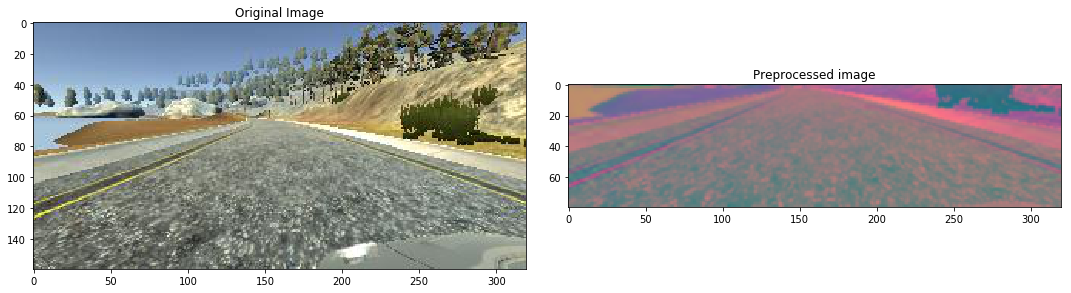

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[1].imshow(preprocessed_image)
ax[1].set_title("Preprocessed image")

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test)))

-0.03762336
(17748, 80, 320, 3)


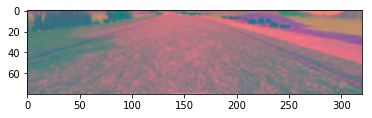

In [0]:
random_number = random.randint(0, len(X_train))
plt.imshow(X_train[random_number])
print (y_train[random_number])
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape = (80, 320, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer=optimizer)
  return model

In [0]:
#tbc=TensorBoardColab()
model = nvidia_model()
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(80, 320, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3),


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 33, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 33, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6336)            

In [0]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 64, verbose = 1, shuffle = 1)


Train on 17748 samples, validate on 4437 samples
Epoch 1/10
17748/17748 [==============================] - 29s 2ms/step - loss: 0.0109 - val_loss: 0.0054
Epoch 2/10
17748/17748 [==============================] - 22s 1ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 3/10
17748/17748 [==============================] - 21s 1ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/10
17748/17748 [==============================] - 21s 1ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/10
17748/17748 [==============================] - 22s 1ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/10
17748/17748 [==============================] - 21s 1ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/10
17748/17748 [==============================] - 21s 1ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/10
17748/17748 [==============================] - 22s 1ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 9/10
17748/17748 [==============================] - 22s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch

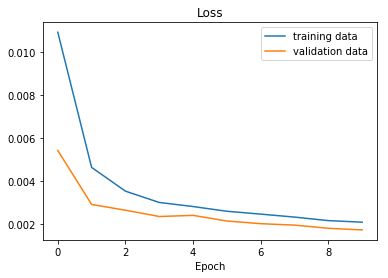

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training data', 'validation data'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()


In [0]:
model.save('/content/gdrive/My Drive/Data Science/Dataset udacity/model.h5')

In [0]:
"""""files.download('model.h5')"""""

(80, 320, 3)
Prediction:  [[-0.07035454]]
Actual:  -0.06046758000000001


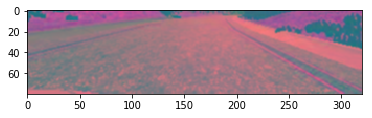

In [0]:
random_number = random.randint(0, len(X_test))
image = X_test[random_number]
print(image.shape)
image = image.reshape(1,80,320,3)
print("Prediction: ", model.predict(image))
print ("Actual: ", y_test[random_number])
plt.imshow(X_test[random_number])
